In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from optuna import Trial
from neuralprophet import NeuralProphet
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv(
    "../input/10min/vcenter.csv", usecols=["date", "value"], parse_dates=["date"]
)
print(df.shape)
df.head()

(52151, 2)


,date,value
0,2020-02-19 09:00:00,10
1,2020-02-19 09:10:00,11
2,2020-02-19 09:20:00,11
3,2020-02-19 09:30:00,11
4,2020-02-19 09:40:00,11


In [3]:
df.rename(columns={"date": "ds", "value": "y"}, inplace=True)
df["ds"] = pd.to_datetime(df["ds"])
df.tail()

,ds,y
52146,2021-02-17 08:10:00,29
52147,2021-02-17 08:20:00,28
52148,2021-02-17 08:30:00,28
52149,2021-02-17 08:40:00,29
52150,2021-02-17 08:50:00,29


In [5]:
train = df.iloc[:int(df.shape[0] * 0.8)]
valid = df.iloc[int(df.shape[0] * 0.2):]
valid["days"] = valid["ds"].dt.date
valid = valid.groupby("days")["y"].agg("mean")

In [6]:
def objective(trial: Trial) -> float:
    params = {
        "epochs": trial.suggest_categorical("epochs", [50, 100, 200, 300, 400, 500]),
        "batch_size": 64,
        "num_hidden_layers": trial.suggest_int("num_hidden_layers", 0, 5),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1),
        "changepoints_range": trial.suggest_discrete_uniform(
            "changepoints_range", 0.8, 0.95, 0.001
        ),
        "n_changepoints": trial.suggest_int("n_changepoints", 20, 35),
        "seasonality_mode": "additive",
        "yearly_seasonality": False,
        "weekly_seasonality": True,
        "daily_seasonality": True,
        "loss_func": "MSE",
    }
    # fit_model
    m = NeuralProphet(**params)
    m.fit(train, freq="1D")
    future = m.make_future_dataframe(train, periods=len(valid), n_historic_predictions=True)

    forecast = m.predict(future)
    valid_forecast = forecast[forecast.y.isna()]
    val_rmse = mean_squared_error(valid_forecast.yhat1, valid, squared=False)

    return val_rmse

In [7]:
study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=20)

[I 2021-05-15 17:57:17,242] A new study created in memory with name: no-name-f580de65-641b-4924-af0d-890278004601
Epoch[100/100]: 100%|██████████| 100/100 [01:30<00:00,  1.11it/s, MSELoss=0.0236, MAE=1.11, RegLoss=0]
[I 2021-05-15 17:58:48,313] Trial 0 finished with value: 16.30156149070461 and parameters: {'epochs': 100, 'num_hidden_layers': 0, 'learning_rate': 0.08675143843171859, 'changepoints_range': 0.89, 'n_changepoints': 31}. Best is trial 0 with value: 16.30156149070461.
Epoch[100/100]: 100%|██████████| 100/100 [01:29<00:00,  1.11it/s, MSELoss=0.0261, MAE=1.2, RegLoss=0]
[I 2021-05-15 18:00:18,758] Trial 1 finished with value: 16.33639785119811 and parameters: {'epochs': 100, 'num_hidden_layers': 1, 'learning_rate': 0.05295088673159155, 'changepoints_range': 0.865, 'n_changepoints': 24}. Best is trial 0 with value: 16.30156149070461.
Epoch[500/500]: 100%|██████████| 500/500 [07:30<00:00,  1.11it/s, MSELoss=0.0253, MAE=1.13, RegLoss=0]
[I 2021-05-15 18:07:50,091] Trial 2 finishe

Epoch[400/400]: 100%|██████████| 400/400 [05:54<00:00,  1.13it/s, MSELoss=0.0251, MAE=1.17, RegLoss=0]
[I 2021-05-15 19:19:17,233] Trial 17 finished with value: 16.570514581744018 and parameters: {'epochs': 400, 'num_hidden_layers': 5, 'learning_rate': 0.041702694511882556, 'changepoints_range': 0.9470000000000001, 'n_changepoints': 29}. Best is trial 9 with value: 14.284093776822472.
Epoch[500/500]: 100%|██████████| 500/500 [07:19<00:00,  1.14it/s, MSELoss=0.0278, MAE=1.21, RegLoss=0]
[I 2021-05-15 19:26:37,495] Trial 18 finished with value: 15.825764255635617 and parameters: {'epochs': 500, 'num_hidden_layers': 2, 'learning_rate': 0.0010029448329502214, 'changepoints_range': 0.907, 'n_changepoints': 26}. Best is trial 9 with value: 14.284093776822472.
Epoch[200/200]: 100%|██████████| 200/200 [02:57<00:00,  1.13it/s, MSELoss=0.028, MAE=1.24, RegLoss=0] 
[I 2021-05-15 19:29:35,364] Trial 19 finished with value: 16.496792028086855 and parameters: {'epochs': 200, 'num_hidden_layers': 3, 

In [8]:
prophet_params = study.best_params
prophet_params["batch_size"] = 64
prophet_params["seasonality_mode"] = "additive"
prophet_params["loss_func"] = "MSE"
prophet_params["weekly_seasonality"] = True
prophet_params["daily_seasonality"] = True
prophet_params["yearly_seasonality"] = False

In [9]:
# model = NeuralProphet() if you're using default variables below.
model = NeuralProphet(**prophet_params)
metrics = model.fit(train, freq="1D")
future = model.make_future_dataframe(train, periods=len(valid), n_historic_predictions=True)
forecast = model.predict(future)

Epoch[400/400]: 100%|██████████| 400/400 [06:03<00:00,  1.10it/s, MSELoss=0.0249, MAE=1.2, RegLoss=0] 


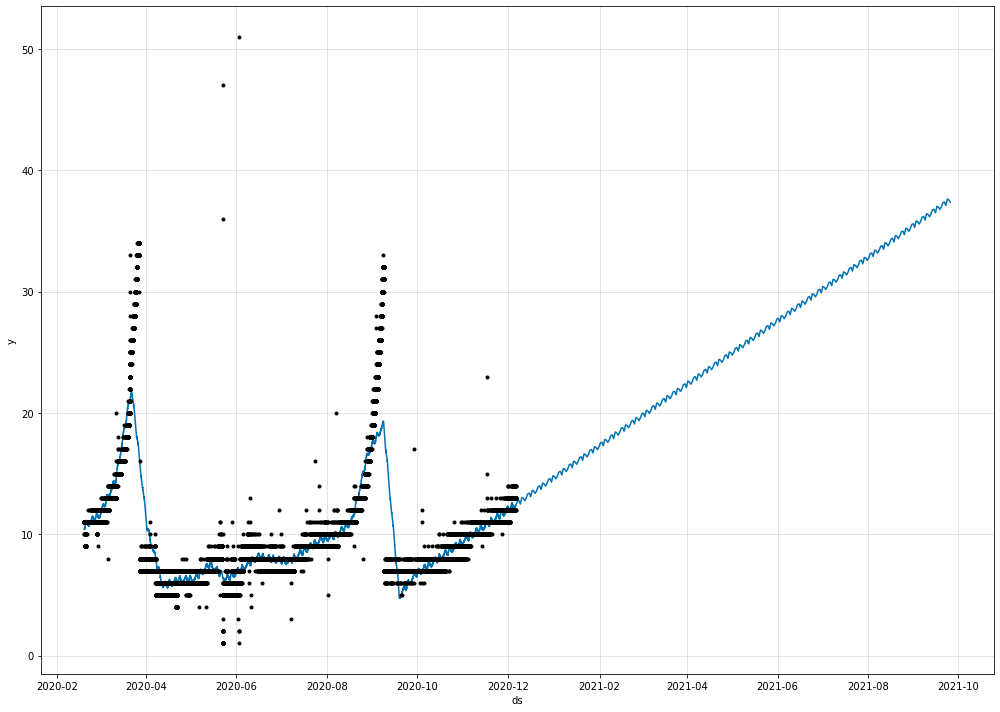

In [10]:
fig, ax = plt.subplots(figsize=(14, 10))
model.plot(forecast, ax=ax)
plt.show()

In [11]:
# model = NeuralProphet() if you're using default variables below.
model = NeuralProphet(**prophet_params)
metrics = model.fit(df, freq="1D")
future = model.make_future_dataframe(df, periods=144, n_historic_predictions=True)
forecast = model.predict(future)

Epoch[400/400]: 100%|██████████| 400/400 [07:51<00:00,  1.18s/it, MSELoss=0.0119, MAE=1.29, RegLoss=0]


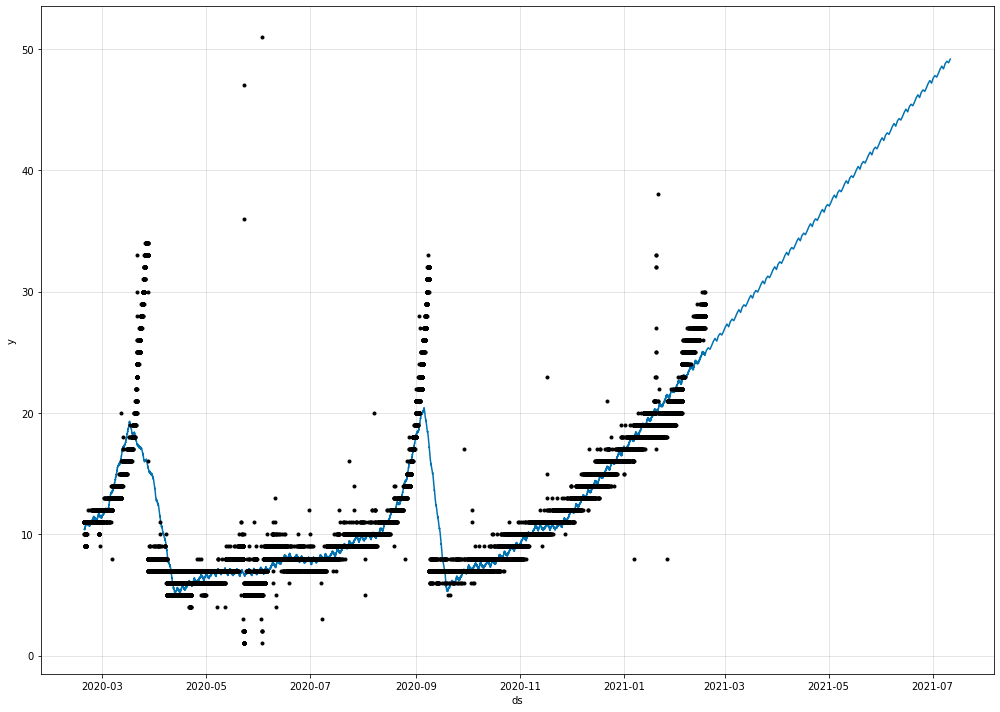

In [12]:
fig, ax = plt.subplots(figsize=(14, 10))
model.plot(forecast, ax=ax)
plt.show()